In [1]:
import pandas as pd
import numpy as np
%matplotlib inline

# Load specific forecasting tools
from statsmodels.tsa.statespace.sarimax import SARIMAX

from statsmodels.graphics.tsaplots import plot_acf,plot_pacf # for determining (p,q) orders
from statsmodels.tsa.seasonal import seasonal_decompose      # for ETS Plots
!pip install pmdarima
from pmdarima import auto_arima                              # for determining ARIMA orders

# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

# Load dataset
df = pd.read_csv('/content/sample_data/RestaurantVisitors.csv',index_col='date',parse_dates=True)
df.index.freq = 'D'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 19.0 MB/s eta 0:00:00


In [2]:
df1 = df.dropna()
df1.tail()

,weekday,holiday,holiday_name,rest1,rest2,rest3,rest4,total
date,,,,,,,,
2017-04-18,Tuesday,0,na,30.0,30.0,13.0,18.0,91.0
2017-04-19,Wednesday,0,na,20.0,11.0,30.0,18.0,79.0
2017-04-20,Thursday,0,na,22.0,3.0,19.0,46.0,90.0
2017-04-21,Friday,0,na,38.0,53.0,36.0,38.0,165.0
2017-04-22,Saturday,0,na,97.0,20.0,50.0,59.0,226.0


In [3]:
# Change the dtype of selected columns
cols = ['rest1','rest2','rest3','rest4','total']
for col in cols:
    df1[col] = df1[col].astype(int)
df1.head()

,weekday,holiday,holiday_name,rest1,rest2,rest3,rest4,total
date,,,,,,,,
2016-01-01,Friday,1,New Year's Day,65,25,67,139,296
2016-01-02,Saturday,0,na,24,39,43,85,191
2016-01-03,Sunday,0,na,24,31,66,81,202
2016-01-04,Monday,0,na,23,18,32,32,105
2016-01-05,Tuesday,0,na,2,15,38,43,98


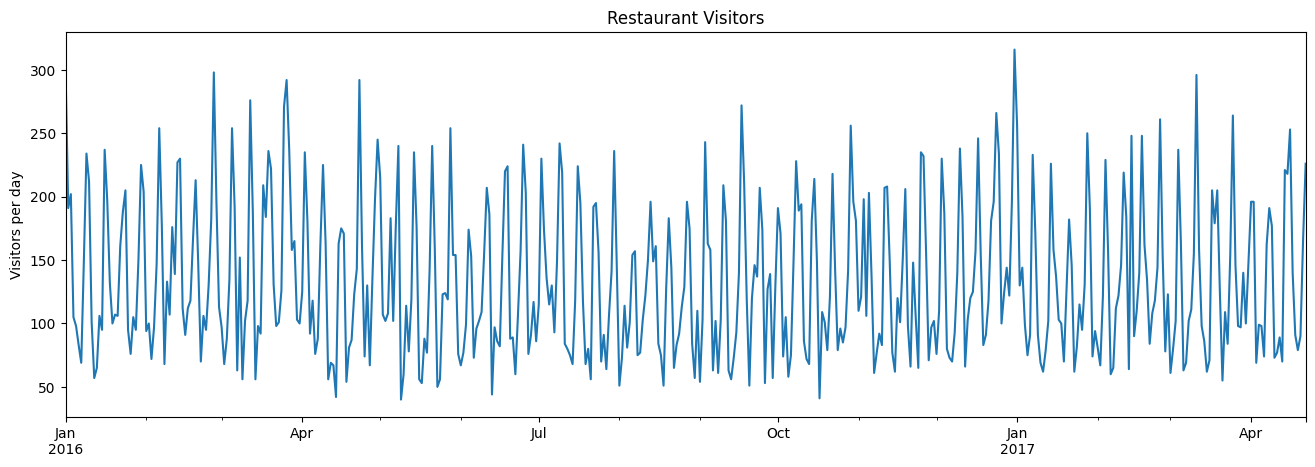

In [4]:
title='Restaurant Visitors'
ylabel='Visitors per day'
xlabel='' # we don't really need a label here

ax = df1['total'].plot(figsize=(16,5),title=title)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

In [5]:
auto_arima(df1['total'],exogenous=df1[['holiday']],seasonal=True,m=7).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 SARIMAX Results                                 
=================================================================================
Dep. Variable:                         y   No. Observations:                  478
Model:             SARIMAX(1, 0, [1], 7)   Log Likelihood               -2381.598
Date:                   Fri, 10 May 2024   AIC                           4771.197
Time:                           12:10:06   BIC                           4787.875
Sample:                       01-01-2016   HQIC                          4777.754
                            - 04-22-2017                                         
Covariance Type:                     opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      4.3650      1.674      2.607      0.009       1.083       7.647
ar.S.L7        0.9661      0.013     76.835      0.000       0.942       0.991
ma.S.L7       -0.7541      0.051    -14.801      0.000      -0.854      -0.654
sigma2      1269.4981     78.083     16.258      0.000    1116.459    1422.537
===================================================================================
Ljung-Box (L1) (Q):                  15.35   Jarque-Bera (JB):                63.60
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.86   Skew:                             0.74
Prob(H) (two-sided):                  0.34   Kurtosis:                         4.00
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [11]:
# Set four weeks for testing
train = df1.iloc[:436]
test = df1.iloc[436:]

#Train out SARIMAX
model = SARIMAX(train['total'],exog=train[['holiday']],order = (1,0,1),seasonal=(1,0,1,7),enforce_invertibility=False)
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  total   No. Observations:                  436
Model:               SARIMAX(1, 0, 1)   Log Likelihood               -2392.644
Date:                Fri, 10 May 2024   AIC                           4793.287
Time:                        12:21:05   BIC                           4809.598
Sample:                    01-01-2016   HQIC                          4799.724
                         - 03-11-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
holiday       62.2012     10.408      5.977      0.000      41.803      82.600
ar.L1          1.0000   1.07e-05   9.34e+04      0.000       1.000       1.000
ma.L1         -0.9954      0.010    -97.065      0.000      -1.015      -0.975
sigma2      3372.3257      0.078   4.32e+04      0.000    3372.173    3372.479
===================================================================================
Ljung-Box (L1) (Q):                  53.90   Jarque-Bera (JB):                30.97
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.85   Skew:                             0.63
Prob(H) (two-sided):                  0.32   Kurtosis:                         2.65
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.8e+20. Standard errors may be unstable.
"""

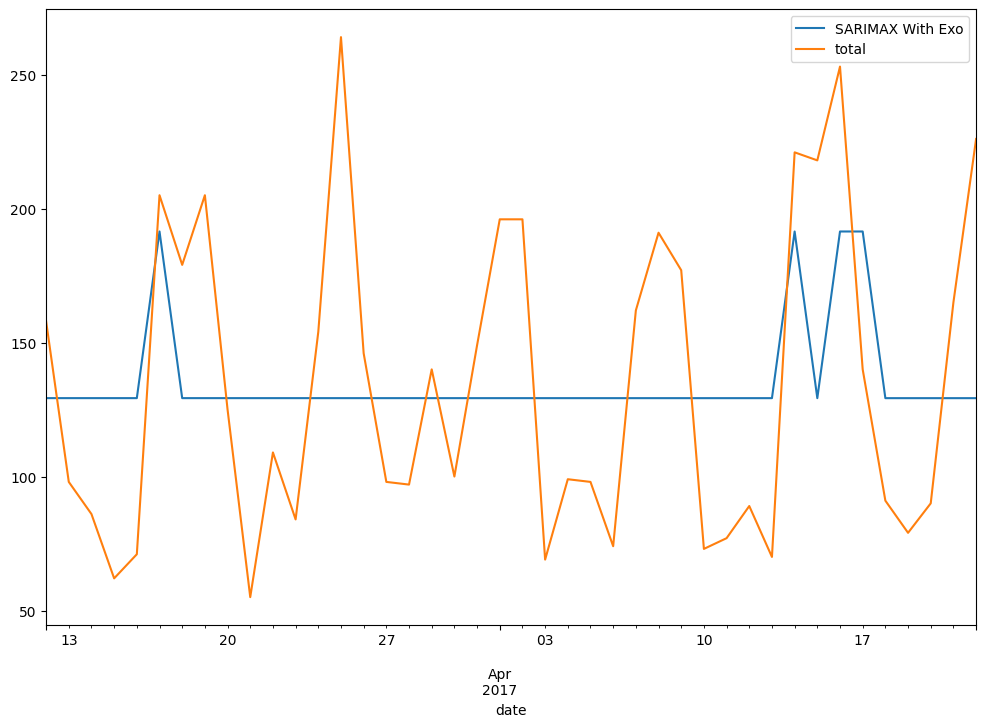

In [12]:
start = len(train)
end = len(train)+len(test)-1
predictions = result.predict(start,end,exog=test[['holiday']]).rename('SARIMAX With Exo')

predictions.plot(figsize=(12,8),legend=True)
test['total'].plot(legend=True);